# 1 Imports

In [13]:
# imports

import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
from items import Item
from loaders import ItemLoader
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import random
import pickle

# 2 Connect to OpenAI & HuggingFace

In [2]:
# Load environment variables in a file called .env

load_dotenv()
api_key = os.getenv('OPEN_API_KEY')

In [3]:
# Load environment variables in a file called .env

load_dotenv()
hf_token = os.getenv('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


# 3 Dataset Treatment

## 3.1 Load Dataset

In [4]:
dataset_names = [
    'Automotive',
    'Electronics',
    'Office_Products',
    'Tools_and_Home_Improvement',
    'Cell_Phones_and_Accessories',
    'Toys_and_Games',
    'Appliances',
    'Musical_Instruments'
]

dataset_names = [
    'Appliances',
    'Musical_Instruments'
]

In [5]:
items = []

for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load(workers=16))

Loading dataset Appliances


100%|██████████| 95/95 [00:20<00:00,  4.63it/s]


Completed Appliances with 29,176 datapoints in 0.4 mins
Loading dataset Musical_Instruments


100%|██████████| 214/214 [00:32<00:00,  6.55it/s]


Completed Musical_Instruments with 67,610 datapoints in 0.6 mins


In [6]:
print(f'A grand total of {len(items):,} items')

A grand total of 96,786 items


## 3.2 Price Investigation

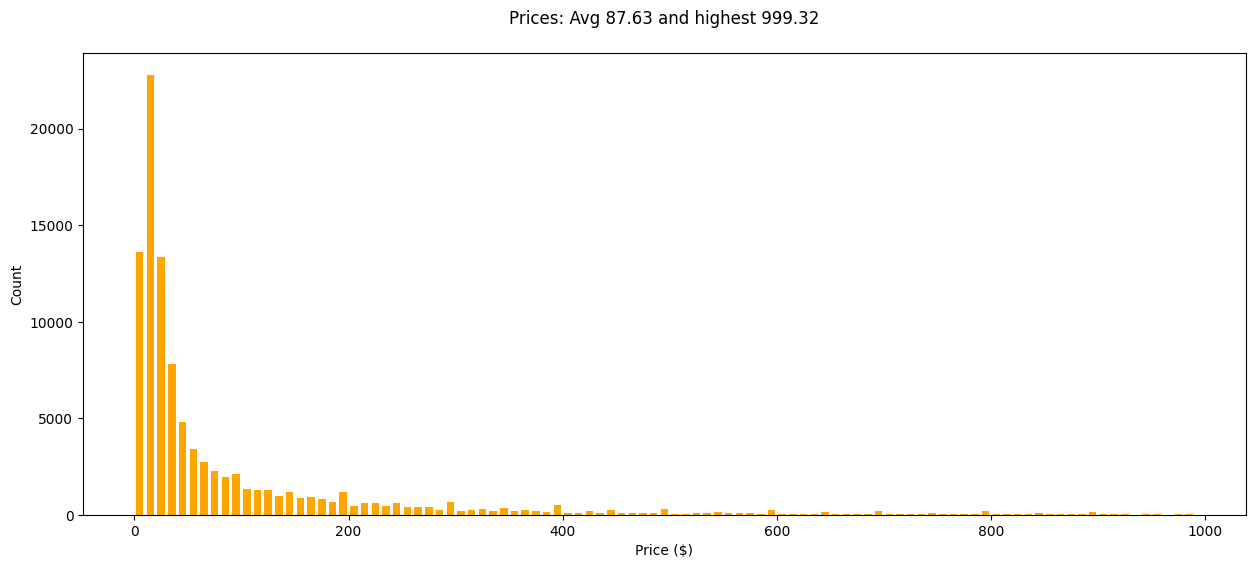

In [8]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=.7, color='orange', bins=range(0, 1000, 10))
plt.show()

## 3.3 Category Investigation

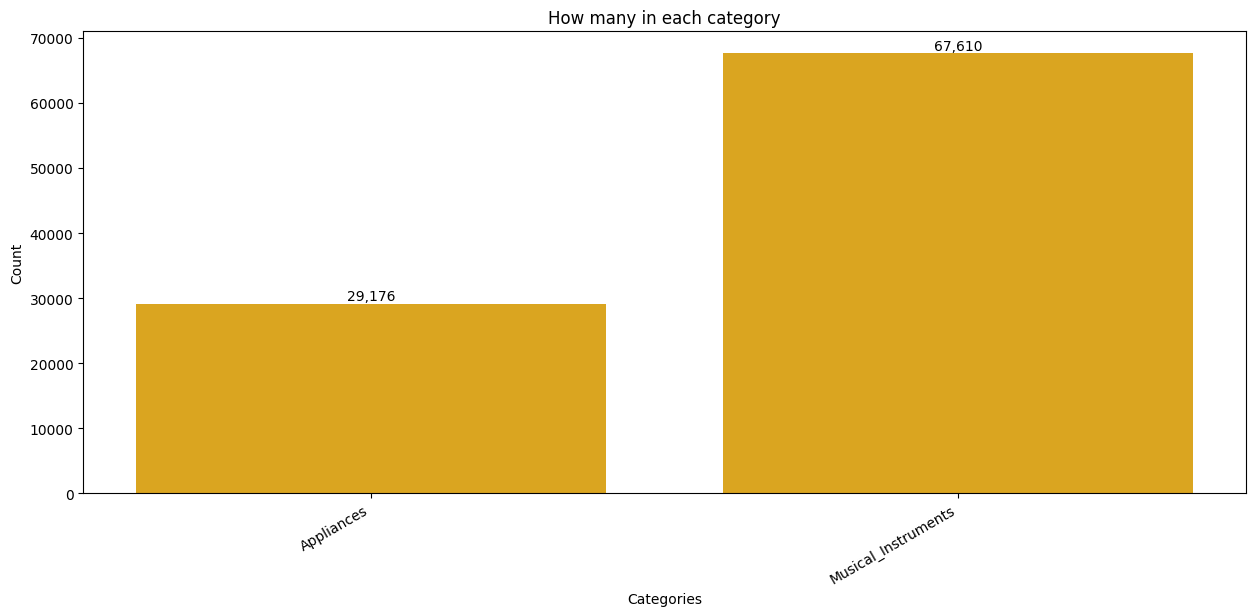

In [14]:
category_counts = Counter()

for item in items:
    category_counts[item.category] += 1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.figure(figsize=(15,6))
plt.bar(categories, counts, color='goldenrod')
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

In [20]:
# Create a dict with a key of each price from $1 to $999 and in the value, put a list of items with that price (to nearest round number)

slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

In [25]:
# Create a dataset called "sample" which tries to more evenly take from the range of prices and gives more weight to items from categories other than Automotive

np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i >= 240:
        sample.extend(slot)
    elif len(slot) <= 1200:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Automotive' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size = 1200, replace = False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 76,877 items in the sample


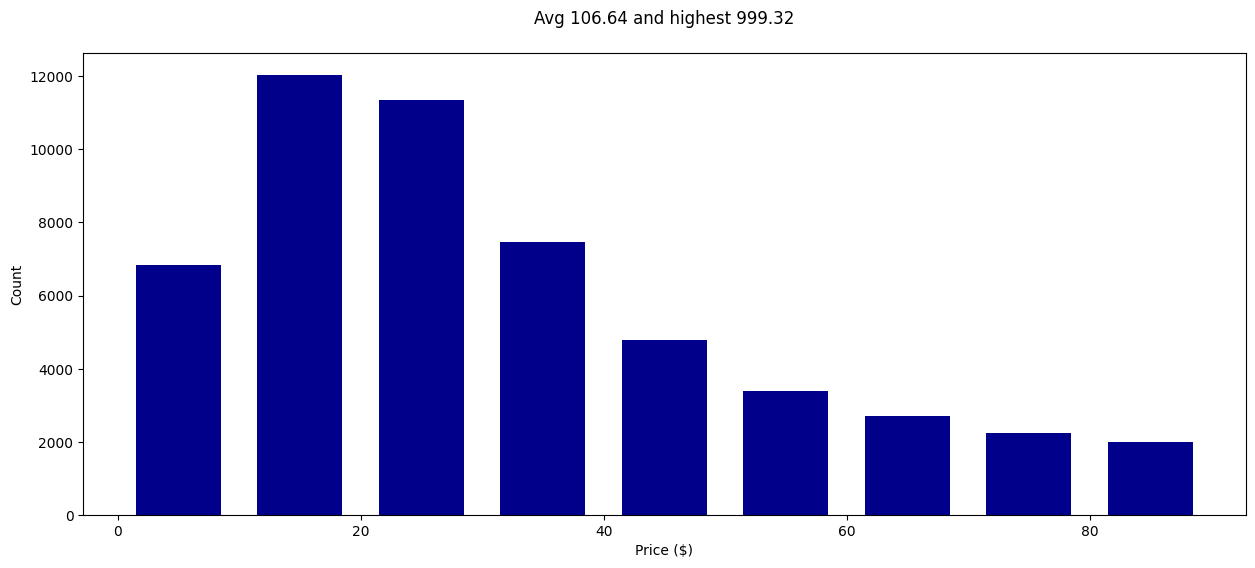

In [27]:
# Plot the distribution of prices in sample

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=.7, color ='darkblue', bins=range(0,100,10))
plt.show()

## 3.4 Prompt Investigation

In [28]:
def report(item):
    prompt = item.prompt
    tokens = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [29]:
report(sample[1])

How much does this cost to the nearest dollar?

Filter for Dyson, Replaces Filters for Dyson DC58 DC59 DC61 DC62 DC74 V6 V7 V8, Standard Mix Material Filter 3 Packs (A+)
Brand Name Smyidel, Weight 3.84 ounces, Dimensions 7.2 x 4.49 x 1.97 inches, Part Compatible Device Dyson DC58, DC58 Animal, DC58 Animal Complete, DC59, DC59 Animal, DC59 Animal Complete, DC59 Animal Exclusive, DC61, DC61 Animal, DC62, DC62 Animal, DC62 Digial Slim, V6 Absolute, V6 Total Clean, V6 Fluffy, V6 Animal, V6 Flexi, V6, V7 series, V8 Animal, V8 Absolute

Price is $1.00
[51284, 193, 193, 11668, 304, 204, 15, 28, 25, 527]
[' Absolute', '\n', '\n', 'Price', ' is', ' ', '$', '1', '.', '00']


# 4 Storage Dataset

In [32]:
random.seed(42)
random.shuffle(sample)
train = sample[:75000]
test = sample [75000:]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 75,000 items and test set of 1,877 items


In [33]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [34]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({'text': train_prompts, 'price': train_prices})
test_dataset = Dataset.from_dict({'text': test_prompts, 'price': test_prices})
dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

## 4.1 Load to HuggingFace

In [35]:
dataset_name_load = 'filipespacheco/pricer-data'
dataset.push_to_hub(dataset_name_load, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/75 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/filipespacheco/pricer-data/commit/9e3c1e59fd8a4e00d476b7b6653cec5f36967da5', commit_message='Upload dataset', commit_description='', oid='9e3c1e59fd8a4e00d476b7b6653cec5f36967da5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/filipespacheco/pricer-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='filipespacheco/pricer-data'), pr_revision=None, pr_num=None)

## 4.2 Save as Pickle File

In [37]:
with open('train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test.pkl', 'wb') as file:
    pickle.dump(test, file)